In [ ]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import AutoModel, AdamW
from datasets import load_dataset
from tqdm import tqdm
from transformers import pipeline, DistilBertTokenizer, DistilBertModel
import matplotlib.pyplot as plt

num_classes = 6
is_textual_metadata = False


In [ ]:


class OrdinalDistilBERT(nn.Module):
    def __init__(self, num_classes = 6, pretrained_model_name = 'distilbert-base-uncased'):
        super(OrdinalDistilBERT, self).__init__()

        self.distilbert = DistilBertModel.from_pretrained(pretrained_model_name)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.activation = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, num_classes)

        """
        self.numerical_network = nn.Sequential(
            nn.Linear(num_numerical_features + 1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        """


    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids = input_ids, attention_mask = attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pre_classifier_activated_output = self.activation((self.pre_classifier(pooled_output)))
        dropout_output = self.dropout(pre_classifier_activated_output)
        logits = self.classifier(dropout_output)

        probs = F.softmax(logits, dim = 1)

        cum_probs = torch.cumsum(probs, dim = 1)

        return cum_probs



In [ ]:
model = OrdinalDistilBERT(num_classes = num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

OrdinalDistilBERT(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [ ]:
dataset = load_dataset("liar")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_data(examples, num_classes, is_textual_metadata):



    def label_mapping(label_idx, num_classes):

      actual_idx = [1, 3, 4, 5, 2, 0]

      result = [float(0)] * num_classes

      i = (actual_idx[label_idx]) // (6 // num_classes)

      for idx in range(i, num_classes):
        result[idx] = float(1)

      return result


    labels = list(map(lambda elem: label_mapping(elem, num_classes), examples['label']))

    combined_text = [statement + " This is what " + speaker + ", a " + party_affiliation + ", said on " + subject + "."  for statement, speaker, subject, party_affiliation in zip(examples['statement'], examples['speaker'], examples['subject'], examples['party_affiliation'])]

    text_to_tokenize = combined_text if is_textual_metadata else examples['statement']

    tokenized = tokenizer(text_to_tokenize, padding= True, truncation=True, max_length=128, return_tensors = 'pt')


    labels = torch.tensor(labels)

    return tokenized, labels

def create_dataset(dataset_split, num_classes = 6, is_textual_metadata = True):
    tokenized, labels = preprocess_data(dataset_split, num_classes, is_textual_metadata)
    dataset = TensorDataset(
        torch.tensor(tokenized['input_ids']),
        torch.tensor(tokenized['attention_mask']),
        torch.tensor(labels)
    )
    return dataset

In [ ]:
dataset = load_dataset("liar")

train_dataset = create_dataset(dataset['train'], num_classes = num_classes, is_textual_metadata = is_textual_metadata)
val_dataset = create_dataset(dataset['validation'], num_classes = num_classes, is_textual_metadata = is_textual_metadata)
test_dataset = create_dataset(dataset['test'], num_classes = num_classes, is_textual_metadata = is_textual_metadata)

train_batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16)

<ipython-input-6-5f7c1057acbf>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tokenized['input_ids']),
<ipython-input-6-5f7c1057acbf>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tokenized['attention_mask']),
<ipython-input-6-5f7c1057acbf>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(labels)


In [ ]:
class CustomBCELoss(nn.Module):
    def __init__(self):
        super(CustomBCELoss, self).__init__()

    def forward(self, outputs, targets):
        outputs = outputs.clamp(min= 0.0001, max= 0.9999)
        loss = -1 * (targets * torch.log(outputs) + (1 - targets) * torch.log(1 - outputs))
        return loss.mean()

loss_fn = CustomBCELoss()

In [ ]:
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr= learning_rate, weight_decay = 0.01)
schedule = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.2)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


100%|██████████| 642/642 [01:29<00:00,  7.20it/s]


Epoch 1, Loss: 0.42722479168128374


100%|██████████| 642/642 [01:28<00:00,  7.24it/s]


Epoch 2, Loss: 0.3613712715443421


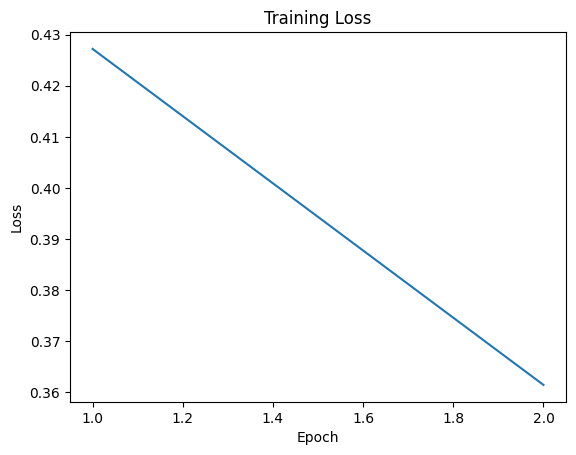

In [ ]:
num_epochs = 2

loss_values = []


loss = None
model.train()
for epoch in range(num_epochs):
    running_loss = 0
    for batch in tqdm(train_loader):
        input_ids, attention_mask,  labels = batch
        input_ids, attention_mask,  labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask)

        optimizer.zero_grad()

        loss = loss_fn(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    schedule.step()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)





    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")

if num_epochs >= 2:
  plt.plot(range(1, num_epochs + 1), loss_values)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.show()

In [ ]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/ordinal_distilbert_weights.pth'))
#print(loss.item())
# 30 +

In [ ]:
import numpy as np

def get_probs(cums):
    result = [cums[0]]
    result.extend([cums[i] - cums[i - 1] for i in range(1, len(cums))])
    return result

def evaluate_model(model, testing_loader):
    model.eval()
    all_outputs, all_targets = [], []

    with torch.no_grad():
        for batch in testing_loader:
            input_ids, attention_mask, targets = batch
            input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)

            outputs = model(input_ids, attention_mask)

            output_probs = [get_probs(output) for output in outputs]
            target_probs = [get_probs(target) for target in targets]

            output_vals = torch.argmax(torch.tensor(output_probs), dim = 1)
            target_vals = torch.argmax(torch.tensor(target_probs), dim = 1)
            all_outputs.append(output_vals)
            all_targets.append(target_vals)

    all_outputs = torch.cat(all_outputs, dim = 0)
    all_targets = torch.cat(all_targets, dim = 0)

    accuracy = (all_outputs == all_targets).float().mean().item()

    return all_outputs.float(), all_targets.float(), accuracy

def weighted_ordinal_accuracy(y_true, y_pred, weight=0.5):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    abs_diff = np.abs(y_true - y_pred)
    mask = (abs_diff == 1) * weight
    weighted_diff = np.dot(abs_diff, mask)
    accuracy = (weighted_diff + np.sum(y_true == y_pred)) / len(y_true)
    return accuracy

def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred)).item()

def within_one_accuracy(y_true, y_pred):
    return torch.mean((torch.abs(y_true - y_pred) <= 1).float()).item()



training_accuracy = evaluate_model(model, train_loader)[2]
y_true, y_pred, accuracy = evaluate_model(model, val_loader)
ordinal_accuracy = weighted_ordinal_accuracy(y_true, y_pred)
mean_absolute_error = mean_absolute_error(y_true, y_pred)
within_one_accuracy = within_one_accuracy(y_true, y_pred)

print("Training Accuracy", training_accuracy)
print("Validation Accuracy:", accuracy)
print('Validation Ordinal Accuracy:', ordinal_accuracy)
print('Validation Mean Absolute Error:', mean_absolute_error)
print('Within 1 Accuracy:', within_one_accuracy)

test_loader = DataLoader(test_dataset, batch_size = 16)
y_true, y_pred, test_accuracy = evaluate_model(model, test_loader)
test_ordinal_accuracy = weighted_ordinal_accuracy(y_true, y_pred)

print("Testing Accuracy:", test_accuracy)
print('Testing Ordinal Accuracy:', test_ordinal_accuracy)

Training Accuracy 0.4333430826663971
Validation Accuracy: 0.2764797508716583
Validation Ordinal Accuracy: 0.46417445482866043
Validation Mean Absolute Error: 1.3076324462890625
Within 1 Accuracy: 0.6518691778182983
Testing Accuracy: 0.2852689027786255
Testing Ordinal Accuracy: 0.45479345284489475
